**Text Mining for AI - Group1 Project** \
First step is acquiring dataset. \
Second step is processing data, for now : \
- we remove duplicates review 
- lower case everything 
- removes rows where the 'app_name' column is null or an empty string

In [12]:
import pandas as pd
import re

df = pd.read_csv('steam_reviews.csv')
#remove duplicate reviews
df = df.drop_duplicates(subset='review_text', keep='first')
#all in lowercase 
df['review_text'] = df['review_text'].str.lower()
df = df[df['review_text'].notna() & (df['review_text'] != '')]
df = df[df['app_name'].notna() & (df['app_name'] != '')]

df = df.drop(columns=['app_id'])
print(df.head(10))
print(df.isna().sum().sum())

         app_name                                        review_text  \
0  Counter-Strike                                    ruined my life.   
1  Counter-Strike  this will be more of a ''my experience with th...   
2  Counter-Strike                      this game saved my virginity.   
3  Counter-Strike  • do you like original games? • do you like ga...   
4  Counter-Strike           easy to learn, hard to master.             
5  Counter-Strike             no r8 revolver, 10/10 will play again.   
6  Counter-Strike          still better than call of duty: ghosts...   
7  Counter-Strike  cant buy skins, cases, keys, stickers - gaben ...   
8  Counter-Strike  counter-strike: ok, after 9 years of unlimited...   
9  Counter-Strike  every server is spanish or french. i can now f...   

   review_score  review_votes  
0             1             0  
1             1             1  
2             1             0  
3             1             0  
4             1             1  
5             1

Saving the data as new csv file. 

In [16]:
#df.to_csv('/Volumes/PotatoExpan/Text_Mining_Project/processed_steam_reviews.csv')
# Specify a separator and ensure headers are included
#df.to_csv('/Volumes/PotatoExpan/Text_Mining_Project/secondtry.csv', sep=';', index=True, header=True)
df.to_csv('cleaned.csv', index=False)

In [17]:
df = pd.read_csv('cleaned.csv')
print(df.head(10))

         app_name                                        review_text  \
0  Counter-Strike                                    ruined my life.   
1  Counter-Strike  this will be more of a ''my experience with th...   
2  Counter-Strike                      this game saved my virginity.   
3  Counter-Strike  • do you like original games? • do you like ga...   
4  Counter-Strike           easy to learn, hard to master.             
5  Counter-Strike             no r8 revolver, 10/10 will play again.   
6  Counter-Strike          still better than call of duty: ghosts...   
7  Counter-Strike  cant buy skins, cases, keys, stickers - gaben ...   
8  Counter-Strike  counter-strike: ok, after 9 years of unlimited...   
9  Counter-Strike  every server is spanish or french. i can now f...   

   review_score  review_votes  
0             1             0  
1             1             1  
2             1             0  
3             1             0  
4             1             1  
5             1

**Sentiment analysis with Vader** \
Here we are perfoming a sentiment analysis with VADER.\
We tryed to apply differnet preparation tecnhiques to the sentences (punctuation, spell check, stop words and etc.) but it didn't gave us a significant improvmance in terms of perfomance. So we decided to leave it's as it is. \
Also, since the only column we have to test on is 'vote_up' which is a binary value, either 0 or 1, we decided to work in this analysis only with positive and negative sentiments. Probably it will influence the perfomance of the model.\
We also decided to removes row with compound score 0 since we'll need to consider it as a neutral sentiment.

In [ ]:
df = pd.read_csv('final_cleaned_dataset.csv')
filtered_df = df[['review_text', 'voted_up']].copy()
print(filtered_df.head())

In [1]:
from nltk.tokenize import sent_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def analyze_review_sentiment(review):
    sentences = sent_tokenize(review)
    compound_scores = []
    for sentence in sentences:
        sentiment_score = analyzer.polarity_scores(sentence)
        compound_scores.append(sentiment_score['compound'])
    if compound_scores: 
        average_compound = sum(compound_scores) / len(compound_scores)
    else:
        average_compound = 0
    return average_compound

filtered_df['compound_score'] = filtered_df['review_text'].apply(analyze_review_sentiment)
filtered_df = filtered_df[filtered_df['compound_score'] != 0]

NameError: name 'filtered_df' is not defined

In [ ]:
from sklearn.metrics import classification_report

threshold = 0.05
filtered_df['predicted_voted_up'] = (filtered_df['compound_score'] > threshold).astype(int)
filtered_df['voted_up'] = filtered_df['voted_up'].astype(int)
report = classification_report(filtered_df['voted_up'], filtered_df['predicted_voted_up'], target_names=['Not Recommended', 'Recommended'])

print(report)

Here we're building a basic LogisticRegression model to use it as a baseline

In [ ]:
from sklearn.linear_model import LogisticRegression

# Train a Logistic Regression model
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train_tfidf, y_train)

# Predictions and Evaluation
y_pred = model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))


**Sentiment analysis with Bert Model** \
Here we are perfoming a sentiment analysis with pre-trained model.\
Since we were unable to run in right in the jupyter notebook, we'll atach the code but all the results will be attached as pictures from PyCharm.

DISCLAIMER: The run took us 8 hours to finish. Don't try it.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
import torch

df = pd.read_csv('/Users/pc/Downloads/final_cleaned_dataset.csv')
filtered_df = df[['review_text', 'voted_up']].copy()

X_train, X_test, y_train, y_test = train_test_split(filtered_df['review_text'], filtered_df['voted_up'], test_size=0.2, random_state=42)

tfidf_vectorizer = TfidfVectorizer(lowercase=True, max_features=10000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')

class ReviewsDataset(Dataset): #to change the format of the dataset
    def __init__(self, texts, labels, tokenizer):
        self.tokenizer = tokenizer
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        inputs = self.tokenizer(text, padding='max_length', truncation=True, max_length=512, return_tensors="pt")
        label = self.labels[idx]
        return {
            'input_ids': inputs['input_ids'][0],
            'attention_mask': inputs['attention_mask'][0],
            'labels': torch.tensor(label, dtype=torch.long)
        }

train_dataset = ReviewsDataset(X_train.tolist(), y_train.tolist(), tokenizer)
test_dataset = ReviewsDataset(X_test.tolist(), y_test.tolist(), tokenizer)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy='steps',
    eval_steps=1500,
    save_steps=1500,
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
)

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english', num_labels=2)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

trainer.train()
trainer.save_model("my_distilbert_model")
tokenizer.save_pretrained("my_distilbert_model")

NameError: name 'pd' is not defined

In [2]:
import numpy as np
import matplotlib.pyplot as plt

predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=-1)

true_labels = predictions.label_ids
report = classification_report(true_labels, pred_labels, target_names=['Negative', 'Positive'])

print(report)

train_logs = [log for log in trainer.state.log_history if 'loss' in log and 'eval_loss' not in log]
eval_logs = [log for log in trainer.state.log_history if 'eval_loss' in log]

train_steps = [log['step'] for log in train_logs]
train_loss = [log['loss'] for log in train_logs]
eval_steps = [log['step'] for log in eval_logs]
eval_loss = [log['eval_loss'] for log in eval_logs]

plt.figure(figsize=(12, 6))
plt.plot(train_steps, train_loss, label='Training Loss')
plt.plot(eval_steps, eval_loss, label='Evaluation Loss', color='red')

plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss')
plt.legend()

plt.show()

NameError: name 'trainer' is not defined

Here we can access Training and Evaluation graph of our model.\
As we can see, the blue line, representing training loss, shows a clear downward trend. It suggests that the model is imporving constantly on the dataset.
As for the evaluation loss, represented by the red line, fluctuates more than the training loss. Initially, it decreases alongside the training loss, indicating that the model is generalizing well to unseen data.\
Around step 20,000, the evaluation loss starts to increase, whereas the training loss continues to decrease. Most probably the cause for it is overfitting. To avoid it our model save the results based on the best_eval_score.


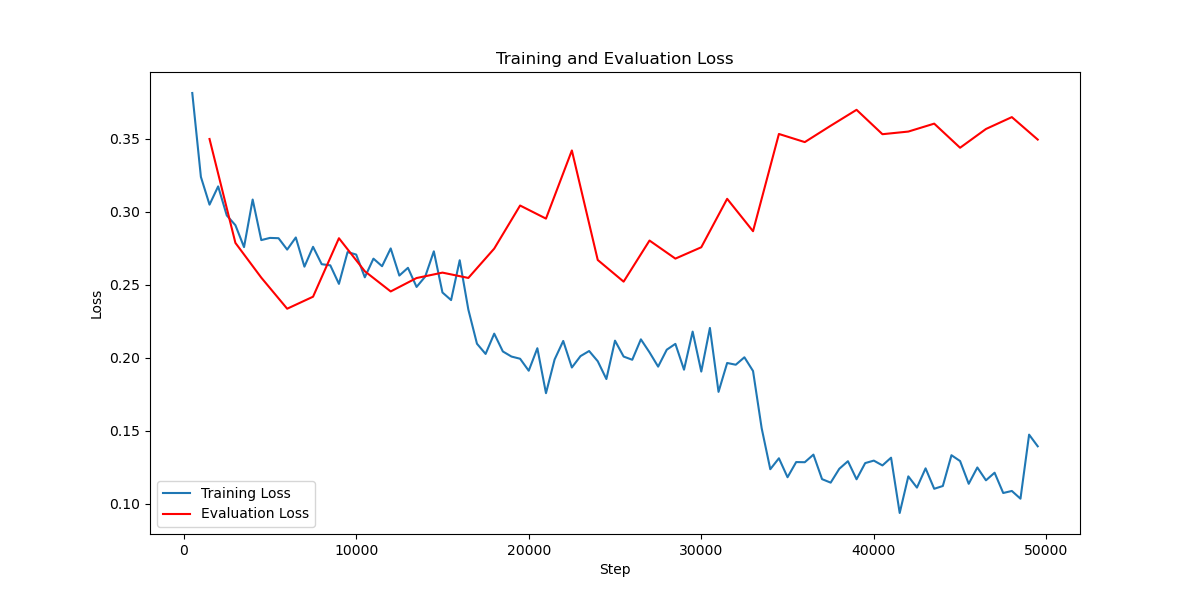


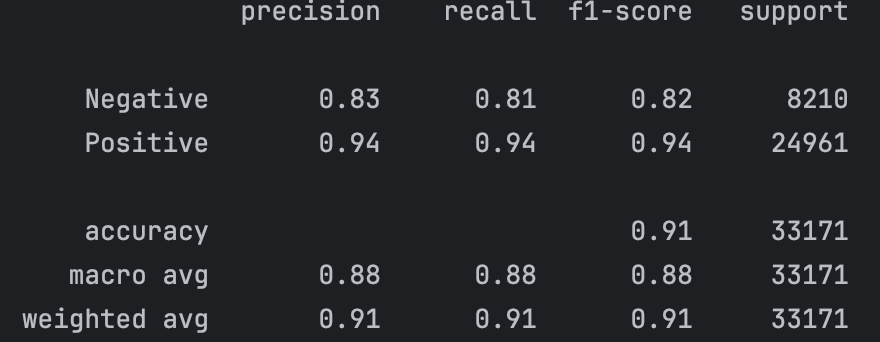

Overall out model is performing quite well, particularly in identifying Positive instances. The slightly lower perfomance for the Negative class could be due to the fact that some of the reviews could be neutral ones and we decided not to access them.

**Accessing test dataset** 

In [4]:
test_df = pd.read_csv('/Users/pc/Downloads/sentiment-topic-test.tsv', sep='\t')
test_df = test_df[test_df['sentiment'] != 'neutral']
test_encodings = tokenizer(test_df['text'].tolist(), truncation=True, padding=True, max_length=512, return_tensors="pt")
class TestDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

# Create the dataset
test_dataset = TestDataset(test_encodings)
predictions = trainer.predict(test_dataset)
pred_logits = predictions.predictions

pred_labels = np.argmax(pred_logits, axis=1)

# Map numeric labels to sentiment labels (adjust according to your specific labels)
label_dict = {0: 'negative', 1: 'positive'}
predicted_sentiments = [label_dict[label] for label in pred_labels]

# Add predictions to the DataFrame
test_df['predicted_sentiment'] = predicted_sentiments
print(test_df[['text', 'predicted_sentiment']])
print(test_df)

# Assuming 'true_sentiment' column exists in your test_df and is in the correct format
true_labels = test_df['sentiment'].tolist()

# Generate the classification report
report = classification_report(true_labels, predicted_sentiments)

print(report)

SyntaxError: invalid syntax (1180068832.py, line 1)

The performance of our model on the provided test dataset is very low (was expected). This could potentially be due to a couple of factors: 

1.Our dataset is appropriate representative for the topic of dataset since steam reviews are tend to be very different from the regular texts with many sarcasm, ambiguous language and etc.

2.The exclusion of neutral sentences from our dataset.


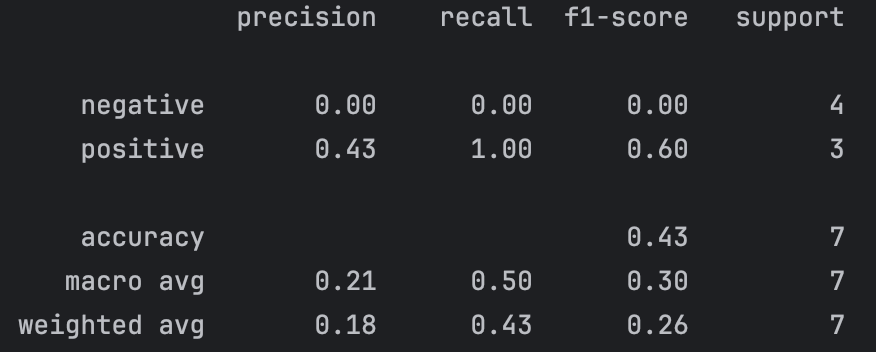